- Ordem de afazeres

    - Construção do dataframe por completo (falta programar as adjacências) e aplicar o K-means

    - Complexidade do problema

    - Formas de resolver

    - Outros algoritmos que resolvem o problema

    - Algoritmos verificadores de resolução

    - Modelagem do problema NP completo para coloração de grafos

    - Abordagem pretendida para o problema

    - Tipos diferentes de sudoku

#### Sobre o problema

- O Sudoku Clássico consiste em uma grade 9x9 `(com um pequeno quadrado (célula) para cada número e uma outra divisão em grades de 3x3, representando as regiões (quadrantes))`, parcialmente preenchida, onde devem ser encontrados os locais corretos para preencher com números de 1 a 9, de modo com que nenhum número se repita na mesma linha, coluna ou quadrante.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Sudoku-by-L2G-20050714.svg/250px-Sudoku-by-L2G-20050714.svg.png" alt="Sudoku Clássico">

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/31/Sudoku-by-L2G-20050714_solution.svg/250px-Sudoku-by-L2G-20050714_solution.svg.png" alt="Sudoku Clássico Resolvido">
</center>

- Em algumas instâncias do sudoku parcialmente preenchido, é possível encontrar mais de uma solução possível, mas como o sudoku é considerado um problema de lógica pura, é esperado que exista somente uma solução possível. 

#### Variantes do sudoku

- O sudoku de 9x9 é o mais conhecido, porém, existem diversas variações do problema com outros tamanhos e abordagens. Abaixo segue uma representação de um sudoku 9x9, mas com seus quadrantes definidos aleatoriamente.

<center>
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/5/5f/Nonomino_Sudoku.svg/220px-Nonomino_Sudoku.svg.png" alt="Sudoku Variante">
</center>

- Modelagem do sudoku de tamanho 10x10

<center>
<img src="10x10.png" alt="Sudoku 10x10" width="250" height="250">
</center>

- Modelagem do sudoku de tamanho 15x15

<center>
<img src="https://static.wikia.nocookie.net/logic-puzzles/images/6/63/15x15_Sudoku.png/revision/latest?cb=20140518185305" alt="Sudoku 15x15">
</center>

#### Abordagem planejada

- Planejamos uma abordagem `não-supervisionada` de máquina, onde vamos modelar a `grade` do sudoku para um formato de grafo. O tamanho da grade do sudoku não vai ser fixo, estamos planejando trabalhar com um `n-sudoku`. Para representar as restrições do sudoku, planejamos utilizar algum algoritmo de coloração de vértices `(em aberto ainda)` e considerar cada cluster como sendo uma cor. Exemplo, para um sudoku 9x9, teríamos 81 vértices e 9 clusters, onde cada vértice é adjacente a todos os outros vértices de sua linha, coluna e região. 

#### Problemas esperados

- Para uma abordagem com n-sudokus, é esperado que para alguns tamanhos de grade, como 10x10 ou 11x11, a forma como os quadrantes vão ser construidos pode acabar se tornando um contra-tempo na hora de visualizar melhor o agrupamento dos clusters. Por isso, optamos em trabalhar com grades que sejam múltiplas de três, de forma a padronizar as saídas e melhorar a visualização. 

- Alguns tamanhos de sudoku, geralmente os sudokus de tamanhos primos, como 11x11, 13x13, 17x17... São considerados `pseudosudokus` por não poderem ter as células distribuidas de forma igualitária em cada quadrante. 

- Segundo problema esperado, devido ao número elevado de ligações e de adjacências entre os vértices, é provável que acabe ocorrendo colisões de dados ao executar o K-means. Estamos pensando em uma abordagem que consiga afastar os dados o máximo possível uns dos outros. `(em aberto ainda)`

<center>
<img src="ligações.png" alt="Sudoku 10x10">
</center>

### Bibliotecas

In [194]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Para o k-means
from sklearn.cluster import KMeans
import plotly.express as px
import plotly.graph_objects as go

# Utilizado para o k-means para que ele não considere que um atributo é mais importante que outros
# OBS: Talvez não iremos utilizar, visto que queremos que o atributo de coloração seja o mais importante
from sklearn.preprocessing import StandardScaler 

### Criação do grafo

In [195]:
def create_sudoku_grafo(N):
    if N % 3 == 0: # It will only accept sudoku sizes that are multiples of 3 to standardize the quadrants
        G = nx.Graph()

        info_vertices_sudoku = []

        for line in range(1, N + 1): # For the lines
            for column in range(1, N + 1): # For de columns
                quadrant = (line - 1) // int(np.sqrt(N)) * int(np.sqrt(N)) + (column - 1) // int(np.sqrt(N)) + 1 # Formula for calculating quadrants in Sudoku
                info_vertices_sudoku.append([line, column, quadrant])
        
        for vertice in info_vertices_sudoku:
            vertice_grafo = int(str(vertice[0]) + str(vertice[1]) + str(vertice[2]))
            G.add_node(vertice_grafo)

        for vertice in info_vertices_sudoku:
            for vertice_adj in info_vertices_sudoku:
                if vertice != vertice_adj:
                    if vertice[0] == vertice_adj[0] or vertice[1] == vertice_adj[1] or vertice[2] == vertice_adj[2]:
                        G.add_edge(int(str(vertice[0]) + str(vertice[1]) + str(vertice[2])), int(str(vertice_adj[0]) + str(vertice_adj[1]) + str(vertice_adj[2])))

        return G
    else:
        print("The size of N is not a multiple of 3.")

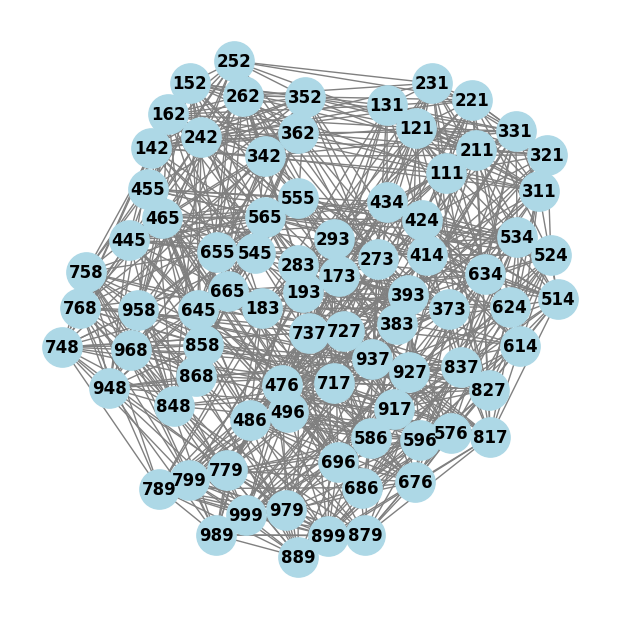

In [196]:
grafo = create_sudoku_grafo(9)
type(grafo)

pos = nx.spring_layout(grafo)

plt.figure(figsize=(6, 6))
nx.draw(grafo, pos, with_labels=True, node_color='lightblue', node_size=800, font_size=12, edge_color='gray', font_weight='bold')

plt.show()

### Criação do dataframe

#### 1º Abordagem: Criar um dataframe a partir do Sudoku em si

In [197]:
def create_sudoku_dataframe(N):

    data = []

    for line in range(1, N + 1): # For the lines
        for column in range(1, N + 1): # For de columns
            quadrant = (line - 1) // int(np.sqrt(N)) * int(np.sqrt(N)) + (column - 1) // int(np.sqrt(N)) + 1
                # Formula for cal6culating quadrants in Sudoku
            data.append([line, column, quadrant, 0])

    columns = ['line_v', 'column_v', 'quadrant_v', 'color']
    data_frame = pd.DataFrame(data, columns = columns)

    return data_frame

In [198]:
N = 9

if N % 3 == 0: # It will only accept sudoku sizes that are multiples of 3 to standardize the quadrants
    sudoku_df = create_sudoku_dataframe(N)
else:
    print("The size of N is not a multiple of 3.")


In [199]:
sudoku_df.head()

,line_v,column_v,quadrant_v,color
0,1,1,1,0
1,1,2,1,0
2,1,3,1,0
3,1,4,2,0
4,1,5,2,0


In [208]:
# Crie um novo DataFrame para trabalhar, mantendo o original intacto
sudoku_resolvido = sudoku_df.copy()

# Inicialize o KMeans com o número de cores diferentes no Sudoku
n_cores = sudoku_df['color'].nunique()
kmeans = KMeans(n_clusters=n_cores, random_state=0)

# Treine o modelo k-means apenas nas colunas 'line_v', 'column_v' e 'quadrant_v'
X = sudoku_df[['line_v', 'column_v', 'quadrant_v']]

# Ajuste o modelo k-means
kmeans.fit(X)

# Adicione os rótulos dos clusters aos dados originais
sudoku_resolvido['cluster'] = kmeans.labels_


In [209]:
sudoku_resolvido

,line_v,column_v,quadrant_v,color,cluster
0,1,1,1,0,0
1,1,2,1,0,0
2,1,3,1,0,0
3,1,4,2,0,0
4,1,5,2,0,0
...,...,...,...,...,...
76,9,5,8,0,0
77,9,6,8,0,0
78,9,7,9,0,0
79,9,8,9,0,0


#### 2º Abordagem: Criar o DataFrame a partir das arestas do grafo

In [200]:
# Obtenha informações das arestas
info_aresta = [(vertice, aresta) for vertice, aresta in grafo.edges]

# Crie um DataFrame
df_aresta = pd.DataFrame(info_aresta, columns=['vertice', 'vertice_adj'])

In [201]:
df_aresta.head()

,vertice,vertice_adj
0,111,121
1,111,131
2,111,142
3,111,152
4,111,162


#### 3º Abordagem: Criar o DataFame a partir da Matriz de Adjacência.

In [202]:
# Obtenha a matriz de adjacência como um array numpy
matriz_adj = nx.to_numpy_array(grafo)

# Crie um DataFrame a partir da matriz de adjacência
df_matriz = pd.DataFrame(matriz_adj, columns=grafo.nodes, index=grafo.nodes)
# Adicione uma coluna 'cor' com valores 0
df_matriz['cor'] = -1

In [234]:
i = 0
for node in grafo.nodes:
    if node in df_matriz.index:
        linha, coluna, quadrante = int(str(node)[0]), int(str(node)[1]), int(str(node)[2])
        i += 15
        if linha == 1:
            df_matriz.at[node, 'cor'] = i


In [235]:
df_matriz

,111,121,131,142,152,162,173,183,193,211,...,927,937,948,958,968,979,989,999,cor,cluster
111,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,6
121,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30,4
131,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,4
142,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,60,2
152,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,75,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,-1,7
968,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,-1,7
979,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,-1,5
989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,-1,5


In [236]:
df_matriz.isnull().sum()

111        0
121        0
131        0
142        0
152        0
          ..
979        0
989        0
999        0
cor        0
cluster    0
Length: 83, dtype: int64

In [237]:
X = df_matriz[['cor']].values

kmeans = KMeans(n_clusters=9, init='k-means++', random_state=0).fit(df_matriz.values)

# Adicione os rótulos de cluster ao DataFrame
df_matriz['cluster'] = kmeans.labels_

In [238]:
df_matriz.head(20)

,111,121,131,142,152,162,173,183,193,211,...,927,937,948,958,968,979,989,999,cor,cluster
111,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15,6
121,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,30,4
131,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,45,4
142,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,60,2
152,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,75,2
162,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,90,8
173,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,105,7
183,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,120,1
193,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,135,1
211,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1,0
